# Basic Engine Example

This is a very simple engine example, that requires no additional modules other than those installed with Bamboo.

- Chamber temperature: 2800 K
- Chamber pressure: 10 bar 

- Total propellant mass flow rate: 1 kg/s
- Coolant mass flow rate: 0.2 kg/s

In [1]:
# Import required modules
import bamboo as bam
import bamboo.cooling as cool
import bamboo.materials
import bamboo.plot

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

### Engine operating point

Pressures, temperatures, mass flow rates, etc.

In [2]:
# Chamber conditions
pc = 10e5                   # Chamber pressure (Pa)
p_amb = 1e5                 # Ambient pressure (Pa) - we'll use sea level atmospheric
Tc = 2800                   # Combustion chamber temperature (K) - would normally get this from an equilibrium program (e.g. Cantera, NASA CEA, ProPEP).

mdot_prop = 1.0             # Propellant mass flow rate (kg/s)
mdot_coolant = 0.2          # Coolant mass flow rate (kg/s)

### Transport properties
Specify the transport properties for the exhaust gas and for the coolant. Note that we can choose to input constant values (`type = 'constants'`) or we can input functions of temperature and pressure (`type = 'functions'`). Here we will use constants, but you can see the 'Introduction to Bamboo.ipynb' notebook to see how to use functions.

Nomenclature:
- `mu` = absolute viscosity (Pa s)
- `k` = thermal conductivity (W/m/K)
- `cp` = isobaric specific heat capacity (J/kg/K)
- `rho` = density (kg/m3)
- `Pr` = Prandtl number (dimensionless)

In [3]:
# Transport properties for the coolant - just use some representative numbers for water
coolant_transport = bam.cooling.TransportProperties(type = "constants", 
                                                    mu = 1.0016e-3, 
                                                    k = 0.598, 
                                                    cp = 4200, 
                                                    rho = 997,
                                                    Pr = 7.56)

# Transport properties for the exhaust gas - just use some representative numbers for CO2
exhaust_transport = bam.cooling.TransportProperties(type = "constants", 
                                                    mu = 3.74e-5, 
                                                    k =  0.0737, 
                                                    Pr = 0.72)


### Bamboo engine set up
We will now use Bamboo to do the cooling system analysis. Will set up:

- Perfect gas model
- Combustion chamber conditions
- Nozzle geometry

NOTE: Area ratio is outside of data range for Rao bell nozzle graphs (minimum 3.7, maximum 47). Using a 15 deg cone nozzle instead.


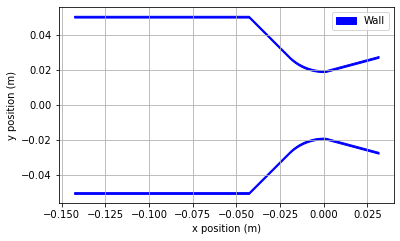


Thrust = 1.397 kN
Specific impulse = 142.49 s



In [4]:
# Set up engine object
perfect_gas = bam.PerfectGas(gamma = 1.31, cp = 830)    # Representative values for CO2 

chamber_conditions = bam.ChamberConditions(pc, 
                                           Tc, 
                                           mdot_prop)

nozzle = bam.Nozzle.from_engine_components(perfect_gas, 
                                           chamber_conditions, 
                                           p_amb, 
                                           type = "rao")

engine = bam.Engine(perfect_gas, 
                    chamber_conditions, 
                    nozzle)

# Chamber geometry
Rc = 0.05                            # Chamber radius (m)
Ac = np.pi * Rc**2                   # Chamber area (m2)
Lc = 0.1                             # Chamber length, up to the start of the nozzle converging section (m)
t_wall = 1.0e-3                      # Inner combustion chamber wall thickness (m)

# Add geometry
engine.add_geometry(chamber_length = Lc,
                    chamber_area = Ac,
                    inner_wall_thickness = t_wall)

engine.plot_geometry()
plt.show()

print(f"""
Thrust = {engine.thrust(p_amb)/1e3:.3f} kN
Specific impulse = {engine.isp(p_amb):.2f} s
""")

### Cooling channels

Add the cooling channel details. We will use 'vertical' channels (`configuration = 'vertical'` as opposed to `configuration = 'spiral'`). This image is an example of 'vertical' channels: https://slideplayer.com/slide/4179683/14/images/6/Cooling+Channels.jpg

In [5]:
# Cooling jacket material properties
copper = cool.Material(E = 117e9,                    # Young's modulus (Pa)
                       sigma_y = float('NaN'),       # Yield stress (Pa) - not necessary for engine.steady_heating_analysis()
                       poisson = 0.34,               # Poisson's ratio
                       alpha = 16.9e-6,              # Thermal expansion coefficient (strain/K)
                       k = 391.2,                    # Thermal conductivity (W/m/K)
                       c = float('NaN'))             # Specific heat capacity - not necessary for engine.steady_heating_analysis()

# Coolant jacket
inlet_T = 298                                         # Coolant inlet temperature (K)
inlet_p0 = 20e5                                       # Coolant inlet stagnation pressure (Pa)
channel_height = 1.0e-3                               # Radial height of the cooling channels (m)
number_of_ribs = 100                                  # Number of 'ribs' (i.e. number of cooling channels)
blockage_ratio = 0.4                                  # Percentage of the annular flow area that is blocked by ribs

# Add exhaust transport properties
engine.add_exhaust_transport(exhaust_transport)

# Add cooling jacket
engine.add_cooling_jacket(copper, 
                          inlet_T, 
                          inlet_p0, 
                          coolant_transport, 
                          mdot_coolant, 
                          configuration = "vertical", 
                          channel_height = channel_height,
                          blockage_ratio = blockage_ratio,
                          number_of_ribs = number_of_ribs)

#Run simulation
heating_data = engine.steady_heating_analysis(to_json = False)

print(f"Maximum wall temperature = {max(heating_data['T_wall_inner']) - 273.15} deg C")

NOTE: No enthalpy data provided for the coolant - will use specific heat capacity to predict temperature rises.
Maximum wall temperature = 403.9066041930538 deg C


### Plot results

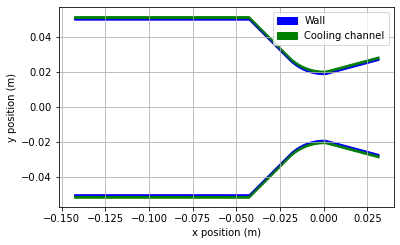

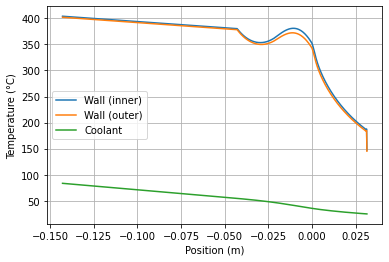

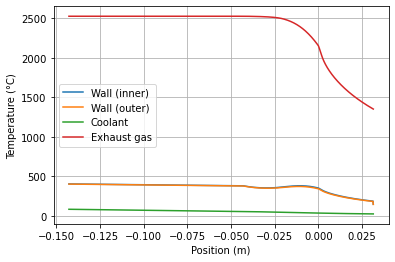

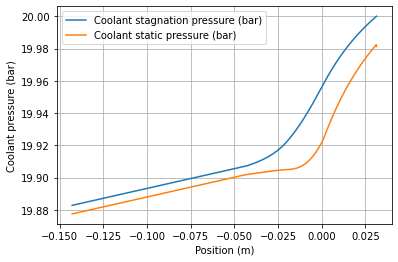

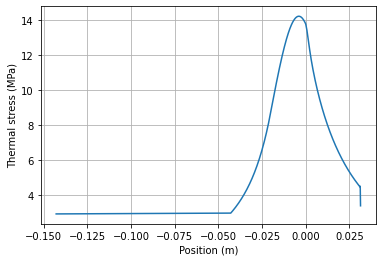

In [6]:
engine.plot_geometry()

bam.plot.plot_temperatures(heating_data)
bam.plot.plot_temperatures(heating_data, show_gas = True)
bam.plot.plot_jacket_pressure(heating_data)
bam.plot.plot_thermal_stress(heating_data)

plt.show()